# debruiter une sinusoide avec un reseau recurrent

In [1]:
# ==========================================================¶
# Date : 14 dec. 2018
# MS Valdom > apprenants > omar attaf, laurent lapasset, didier le picaut
# version = 2.0
# ==========================================================

In [3]:
#================
# objectif : DEBRUITER UN SIGNAL SINUS AVEC UN RNN
#================

In [4]:
# probleme : avec un signal sinus bruite en entree d un RNN > debruiter le signal en sortie du RNN

In [5]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import math, random
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
import torch
import torch.nn as nn
from torch.autograd import Variable

In [7]:
# Debut du decompte du temps
import time
start_time = time.time()

In [8]:
# creation signal + ajout de bruit

# signal sinus sans bruit
def sine(X, signal_freq=60.):
    return np.sin(2 * np.pi * (X) / signal_freq)

# bruit uniforme
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.uniform(noise_range[0], noise_range[1], size=Y.shape)
    return Y + noise

# sinus + bruit
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = sine(X + random_offset)
    inp = noisy(out)
    return inp, out

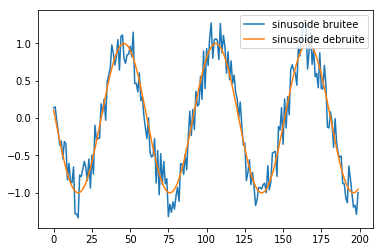

In [9]:
# graphe sinusoide bruite
inp, out = sample(200)
plt.plot(inp, label='sinusoide bruitee')
plt.plot(out, label ='sinusoide debruite')
plt.legend()

In [10]:
# generer des points 
def create_dataset(n_samples=10000, sample_size=100):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out

In [11]:
# train, test
data_inp, data_out = create_dataset()
train_inp, train_out = data_inp[:8000], data_out[:8000]
test_inp, test_out = data_inp[8000:], data_out[8000:]

In [12]:
# RNN adapte a notre probleme
# sinusoide a debruiter => dim d entree = 1. 
# donc 1 RNN simple couche avec 30 unités cachées peut suffir

In [ ]:
# =============
# MODELE 1
# =============

In [13]:
# modele RNN
# ---------------
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r=CustomRNN(input_dim, hidden_size, 1)

In [14]:
# sanity check modele forme 
r

CustomRNN(
  (rnn): RNN(1, 30, batch_first=True)
  (linear): Linear(in_features=30, out_features=1, bias=True)
  (act): Tanh()
)

In [15]:
# Train = apprentissage du RNN

predictions = []
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

0 tensor(0.6711)
20 tensor(0.1266)
40 tensor(0.1128)
60 tensor(0.1104)
80 tensor(0.1080)
100 tensor(0.0960)
120 tensor(0.1178)
140 tensor(0.1085)
160 tensor(0.1039)
180 tensor(0.0969)
200 tensor(0.0826)
220 tensor(0.0778)
240 tensor(0.1137)
260 tensor(0.0988)
280 tensor(0.0906)
300 tensor(0.0779)


In [17]:
# Test = la prediction
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [18]:
# Test = la fonction de perte
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

tensor(0.0778)


Text(0.5, 1.0, 'RNN simple - echantillon = 100 ')

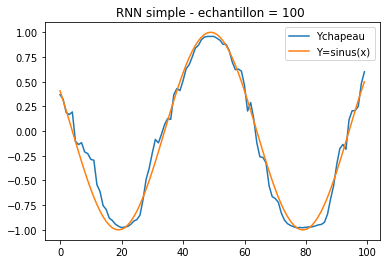

In [25]:
# Visualiser un échantillon de débruitage
sample_num  =  100
plt.plot ( pred_t [ sample_num ] . data . numpy (),  label = 'Ychapeau' ) 
plt.plot ( test_out [ sample_num ],  label = 'Y=sinus(x)' ) 
plt.legend()
plt.title ( "RNN simple - echantillon = {} " . format ( sample_num ))

In [ ]:
# analyse : avec une perte = 0.0778, il reste encore du bruit
# solution mise en place d un RNN ameliorer ==> RNN bi-directionnel

In [ ]:
# =============
# MODELE 2
# =============

In [ ]:
# Réseaux de neurones récurrents bidirectionnels
# ----------------------------------------------
# source : https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks
# Les réseaux de neurones récurrents bidirectionnels ( BRNN ) connectent deux couches cachées de directions opposées
# à la même sortie. Avec cette forme d' apprentissage en profondeur générative , 
# la couche de sortie peut obtenir simultanément des informations d'états passés (en arrière) 
# et futurs (en avant). Inventés en 1997 par Schuster et Paliwal,
# Les BRNN ont été introduits pour augmenter la quantité d'informations d'entrée disponibles sur le réseau. 
# Par exemple, les perceptrons multicouches (MLP) et les réseaux neuronaux à retardement (TDNN)
# ont des limites en termes de flexibilité des données d'entrée, car ils nécessitent que leurs données 
# d'entrée soient corrigées. Réseau de neurones récurrents standard(RNN) ont également des restrictions
# car les informations d'entrée futures ne peuvent pas être atteintes à partir de l'état actuel. 
# Au contraire, les BRNN n’exigent pas que leurs données d’entrée soient corrigées. 
# En outre, leurs informations d'entrée futures sont accessibles à partir de l'état actuel.
# Les BRNN sont particulièrement utiles lorsque le contexte de l’entrée est nécessaire.
# Par exemple, dans la reconnaissance de l'écriture manuscrite, la performance peut être 
# améliorée par la connaissance des lettres situées avant et après la lettre actuelle.

In [30]:
# modele 2 : bi-directionnel + dropout
# ---------------
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.3)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [31]:
# sanity check
r

CustomRNN(
  (rnn): RNN(1, 30, batch_first=True, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
  (act): Tanh()
)

In [32]:
# modele en train

predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(301):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

0 tensor(0.6838)
20 tensor(0.0912)
40 tensor(0.0743)
60 tensor(0.0705)
80 tensor(0.0718)
100 tensor(0.0651)
120 tensor(0.0622)
140 tensor(0.0646)
160 tensor(0.0620)
180 tensor(0.0548)
200 tensor(0.0498)
220 tensor(0.0536)
240 tensor(0.0517)
260 tensor(0.0537)
280 tensor(0.0459)
300 tensor(0.0433)


In [33]:
# modele en test
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [34]:
# la fonction de perte
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

tensor(0.0444)


Text(0.5, 1.0, 'RNN bidirectionnel - echantillon = 100 ')

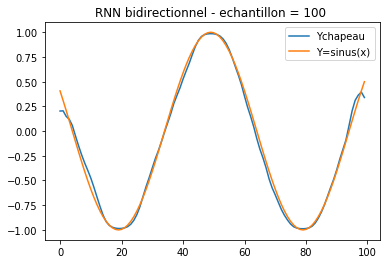

In [35]:
# Visualiser un échantillon de débruitage
sample_num  =  100
plt.plot ( pred_t [ sample_num ] . data . numpy (),  label = 'Ychapeau' ) 
plt.plot ( test_out [ sample_num ],  label = 'Y=sinus(x)' ) 
plt.legend()
plt.title ( "RNN bidirectionnel - echantillon = {} " . format ( sample_num ))

In [ ]:
# analyse modele 2 : avec une perte = 0.0444, il reste encore un peu du bruit
# sur les premiers et derniers points ?
# mais notre en terme de valeur perte modele 2 > modele 1
# solution mise en place d un RNN ameliorer ==> architecture RNN remplace par une architecture GRU

In [ ]:
# =============
# MODELE 3
# =============

In [ ]:
# https://en.wikipedia.org/wiki/Gated_recurrent_unit
# ----------------------------------------------------
# Les unités récurrentes gated ( GRU ) sont un mécanisme de déclenchement dans les réseaux de neurones récurrents ,
# introduit en 2014 par Kyunghyun Cho et al.
# Leur performance sur la modélisation musicale polyphonique et la modélisation des signaux de parole
# s’est avérée similaire à celle de la mémoire à court terme (LSTM). 
# Cependant, il a été démontré que les unités GRU présentent de meilleures performances sur des jeux de données
# plus petits.
# Ils ont moins de paramètres que LSTM, car ils n’ont pas de porte de sortie.

In [39]:
# modele GRU
# ---------------
bidirectional = True
if bidirectional:
    num_directions = 2
else:
    num_directions = 1
class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True, bidirectional=bidirectional, dropout=0.3)
        self.linear = nn.Linear(hidden_size*num_directions, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r=CustomRNN(input_dim, hidden_size, 1)

In [40]:
# sanity check
r

CustomRNN(
  (rnn): GRU(1, 30, batch_first=True, dropout=0.3, bidirectional=True)
  (linear): Linear(in_features=60, out_features=1, bias=True)
  (act): Tanh()
)

In [41]:
# modele en train
predictions = []

optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.L1Loss()

for t in range(201):
    hidden = None
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    predictions.append(pred.data.numpy())
    loss = loss_func(pred, out)
    if t%20==0:
        print(t, loss.data[0])
    loss.backward()
    optimizer.step()

0 tensor(0.5939)
20 tensor(0.0997)
40 tensor(0.0896)
60 tensor(0.0832)
80 tensor(0.0645)
100 tensor(0.0494)
120 tensor(0.0450)
140 tensor(0.0372)
160 tensor(0.0356)
180 tensor(0.0344)
200 tensor(0.0332)


In [42]:
# modele en test
t_inp = Variable(torch.Tensor(test_inp.reshape((test_inp.shape[0], -1, 1))), requires_grad=True)
pred_t = r(t_inp)

In [43]:
# la fonction de perte
print(loss_func(pred_t, Variable(torch.Tensor(test_out.reshape((test_inp.shape[0], -1, 1))))).data[0])

tensor(0.0339)


Text(0.5, 1.0, 'RNN bidirectionnel GRU - echantillon = 100 ')

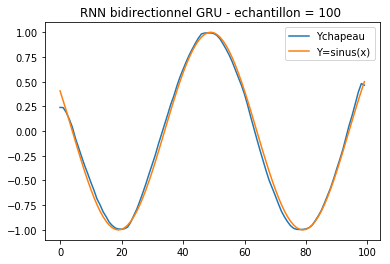

In [44]:
# Visualiser un échantillon de débruitage
sample_num  =  100
plt.plot ( pred_t [ sample_num ] . data . numpy (),  label = 'Ychapeau' ) 
plt.plot ( test_out [ sample_num ],  label = 'Y=sinus(x)' ) 
plt.legend()
plt.title ( "RNN bidirectionnel GRU - echantillon = {} " . format ( sample_num ))

In [ ]:
# analyse modele 3 : avec une perte = 0.0339, il reste encore un peu du bruit
# sur les premiers et derniers points ?
# mais notre en terme de valeur perte modele 3 > modele 2 > modele 1
# graphiquement Ychapeau GRU fir mieuxY que les autres modeles

In [46]:
# Affichage du temps d execution
print("Temps d execution : %s minutes --- secondes" % round((time.time() - start_time)/60),2)

Temps d execution : 151 minutes --- secondes 2
